# Needed libraries

In [254]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import time
from scipy import stats
import seaborn as sbn
import pandas as pd
import h5py
import os
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter
import glob


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [3]:
print('numpy version:', np.__version__)
print('matplotlib version:', mpl.__version__)
print('torch version:', torch.__version__)

# Check if gpu is available
if torch.cuda.is_available():
    device = 'gpu'
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')


numpy version: 1.22.4
matplotlib version: 3.5.2
torch version: 2.4.1+cu121
Using GPU


In [4]:
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        # Convertir las imágenes y etiquetas a tensores
        image = torch.tensor(self.x_data[idx], dtype=torch.float32)
        label = torch.tensor(self.y_data[idx], dtype=torch.float32)
        return image, label

In [5]:
R_bins = np.geomspace(1,100,20)

In [6]:
arqB_8ch = np.loadtxt("../data/red_curve_data.csv", delimiter=",", skiprows=1)

## Custom functions

In [ ]:
def estimate_saliency_map(model, image, radial_bin, noise_levels = np.array([1e-3,1e-3,1e-3,1e-3,1e-3,1e-2,1e-5,1e-7]).reshape(1,8,1,1),
                         num_perturbations = 20):
    
    image.requires_grad = True  # Enable gradient computation

    # Initialize an empty tensor to accumulate gradients
    accumulated_saliency = torch.zeros_like(image)

    for _ in range(num_perturbations):
        # Add Gaussian noise to the image
        noisy_image = image + torch.Tensor(noise_levels) * torch.randn_like(image)

        # Forward pass
        output = model(noisy_image)

        # Zero out any previous gradients
        model.zero_grad()

        # Compute the gradient of the output with respect to the target index
        output[0, radial_bin].backward(retain_graph=True)

        # Accumulate the gradients
        accumulated_saliency += image.grad

    # Average the accumulated saliency maps
    accumulated_saliency /= num_perturbations

    # Get the final saliency map (absolute value of gradients)
    saliency_map = accumulated_saliency.abs().squeeze().detach().cpu().numpy()
    
    return saliency_map

In [125]:
def dm_from_stellar(stellar_profile, num_smass_bins = 10):
    dm_profile     = np.zeros_like(stellar_profile)
    dm_profile_std = np.zeros_like(stellar_profile)
    
    for i in range(20):
        stellar_mass_bins = np.linspace(np.min(np.log10(labels[:,1,i])), np.max(np.log10(labels[:,1,i])), num_smass_bins)
        aux_bin = np.digitize(np.log10(stellar_profile[i]), stellar_mass_bins)

        ind = np.where( (np.log10(labels[:,1,i]) > stellar_mass_bins[aux_bin-1]) & 
                  (np.log10(labels[:,1,i]) < stellar_mass_bins[aux_bin]) )[0]
        dm_profile[i] = np.mean(np.log10(labels[ind,0,i]))
        dm_profile_std[i] = np.std(np.log10(labels[ind,0,i]))
        
    return dm_profile, dm_profile_std

# Reading data

In [380]:
images = np.load('../data/TNGgalaxies_28_02/noisy_images.npy')
labels = np.load('../data/TNGgalaxies_28_02/labels.npy')

In [381]:
dm_prior_profile     = np.mean(np.log10(labels[:,0,:]), axis = 0)
dm_prior_profile_std = np.std(np.log10(labels[:,0,:]), axis = 0)

dm_quantiles = np.quantile(np.log10(labels[:,0,:]), axis = 0, q = [0.1,0.25,0.75,0.9])

In [382]:
properties = np.load('../data/TNGgalaxies_28_02/properties.npy')

In [383]:
properties.shape

(2972, 20)

In [384]:
print(f'There are {len(np.where(np.isnan(images) == True)[0])} nans in images')
print(f'There are {len(np.where(np.isnan(labels) == True)[0])} nans in labels')

There are 3086 nans in images
There are 0 nans in labels


In [385]:
images = np.nan_to_num(images, nan=0)

In [260]:
#images = np.moveaxis(images, 1, -1)

In [261]:
#images = images[:100,:,:,:]
#labels = labels[:100,:]

In [386]:
#images = images[:,:5,:,:]
#images = images[:,0,:,:].reshape(nobs,1,npix,npix)

In [387]:
nobs,nch, npix, _ = images.shape

In [388]:
nch

8

In [389]:
np.random.seed(28890)
random_ind = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_size = int(0.7 * nobs)
val_size   = int(0.2 * nobs)
test_size  = nobs - train_size - val_size

train_ind = random_ind[:train_size]
val_ind   = random_ind[train_size:(val_size + train_size)]
test_ind  = random_ind[-test_size:]

In [390]:
x_trainset = images[train_ind,:,:,:]
x_valset   = images[val_ind,:,:,:]
x_testset  = images[test_ind,:,:,:]

y_trainset = np.log10(labels[train_ind,0,:])
y_valset   = np.log10(labels[val_ind,0,:])
y_testset  = np.log10(labels[test_ind,0,:])

In [391]:
min_x = np.min(x_trainset, axis = (0,2,3))
max_x = np.max(x_trainset, axis = (0,2,3))

min_x = min_x[:, np.newaxis, np.newaxis]
max_x = max_x[:, np.newaxis, np.newaxis]

min_y = np.min(y_trainset, axis = 0)
max_y = np.max(y_trainset, axis = 0)

In [392]:
x_trainset = (x_trainset - min_x) / (max_x - min_x)
x_valset   = (x_valset - min_x) / (max_x - min_x)
x_testset  = (x_testset - min_x) / (max_x - min_x)

y_trainset = (y_trainset - min_y) / (max_y - min_y)
y_valset   = (y_valset - min_y) / (max_y - min_y)
y_testset  = (y_testset - min_y) / (max_y - min_y)

In [393]:
min_y.shape

(20,)

## Plots

In [332]:
np.log10(labels[:,1,i*4+j]).min()

10.001017565935886

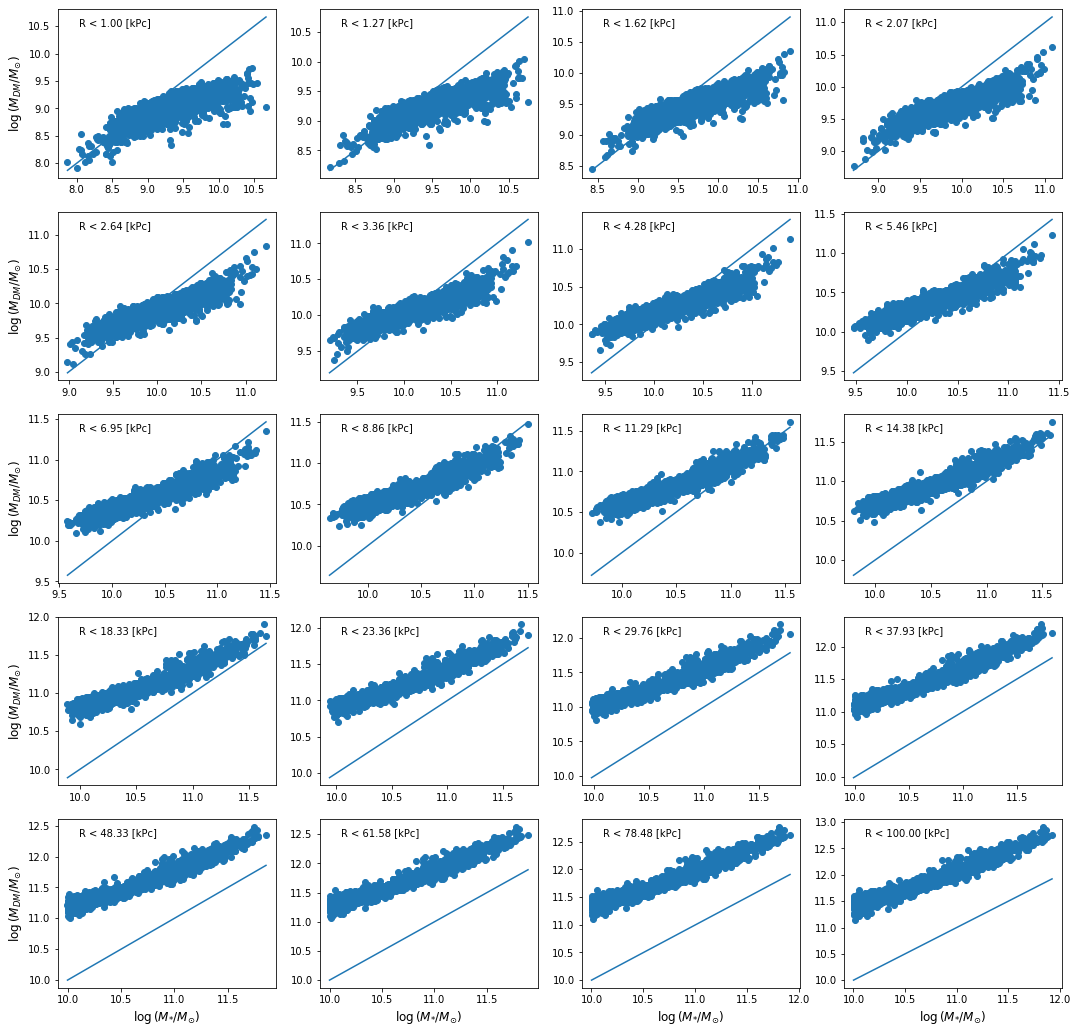

In [334]:
fig, ax = plt.subplots(5,4, figsize = (18,18))

for i in range(5):
    for j in range(4):

        ax[i,j].scatter(np.log10(labels[:,1,i*4+j]), np.log10(labels[:,0,i*4+j]))
        ax[i,j].plot([np.log10(labels[:,1,i*4+j]).min(), np.log10(labels[:,1,i*4+j]).max()],
                     [np.log10(labels[:,1,i*4+j]).min(), np.log10(labels[:,1,i*4+j]).max()])
        
        if i == 4: ax[i,j].set_xlabel('$\log{(M_{*} / M_{\odot})}$', fontsize = 12)
        if j == 0: ax[i,j].set_ylabel('$\log{(M_{DM} / M_{\odot})}$', fontsize = 12)
        ax[i,j].text(0.1,0.9,'R < {:.2f} [kPc]'.format(R_bins[i*4+j]), transform = ax[i,j].transAxes)
        
plt.savefig('../graphs/StellarVSDM.pdf')

In [18]:
labels.shape

(2972, 3, 20)

In [43]:
stellar_mass_bins = np.linspace(np.min(np.log10(labels[:,1,nbin])), np.max(np.log10(labels[:,1,nbin])), 10)

In [51]:
stellar_mass_bins

array([ 8.70095989,  8.96562015,  9.23028042,  9.49494069,  9.75960096,
       10.02426122, 10.28892149, 10.55358176, 10.81824203, 11.0829023 ])

In [49]:
np.digitize(10, stellar_mass_bins)

5

In [52]:
radial_bin = 3 
mstellar = 10
aux_bin = np.digitize(mstellar, stellar_mass_bins)

ind = np.where( (np.log10(labels[:,1,radial_bin]) > stellar_mass_bins[aux_bin-1]) & 
          (np.log10(labels[:,1,radial_bin]) < stellar_mass_bins[aux_bin]) )[0]

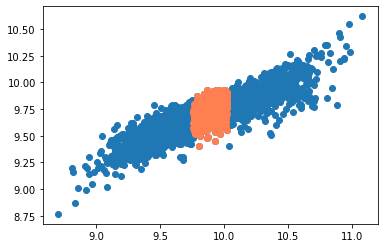

In [53]:
plt.scatter(np.log10(labels[:,1,radial_bin]), np.log10(labels[:,0,radial_bin]))
plt.scatter(np.log10(labels[ind,1,radial_bin]), np.log10(labels[ind,0,radial_bin]), c = 'coral')
#plt.plot([8,11],[8,11], c = 'coral')

In [127]:
y_predicted_from_stellar = np.zeros((test_size, 20))
y_predicted_from_stellar_std = np.zeros((test_size, 20))
for i in range(test_size):
    dm_aux, dm_std = dm_from_stellar(labels[test_ind[i],1,:],num_smass_bins = 10)
    y_predicted_from_stellar[i,:] = dm_aux
    y_predicted_from_stellar_std[i,:] = dm_std

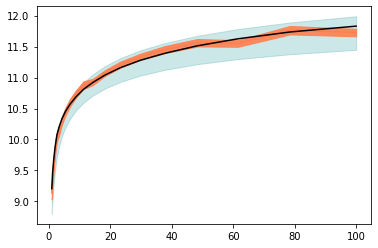

In [134]:
igal = 123
plt.fill_between(R_bins, (dm_prior_profile + dm_prior_profile_std), (dm_prior_profile - dm_prior_profile_std), color = 'darkcyan', alpha = 0.2)
plt.plot(R_bins, y_predicted_from_stellar[igal,:], color = 'coral')
plt.fill_between(R_bins, (y_predicted_from_stellar[igal,:] + y_predicted_from_stellar_std[igal,:]), (y_predicted_from_stellar[igal,:] - y_predicted_from_stellar_std[igal,:]), color = 'coral', alpha = 0.9)
plt.plot(R_bins, np.log10(labels[test_ind[igal],0,:]), c = 'black')

#plt.yscale('log')
#plt.xscale('log')

# Playing with CNNs

In [394]:
# network parameters
input_shape = (nch, npix, npix) # Input shape (#rows, #cols, #channels)
actFunction = 'relu'

# Hidden layers dimensions
intermediate_dim1 = 500
intermediate_dim2 = 400
intermediate_dim3 = 300
intermediate_dim4 = 200
output_dim        = y_trainset.shape[1]

## First let's check that it overfit 1 batch

* It seems to converge to MSE = 0.0451 (without batch normalization nor dropout)

In [33]:
class ConvNet(nn.Module):
    def __init__(self, input_shape, intermediate_dim1, intermediate_dim2, intermediate_dim3, intermediate_dim4, output_dim, actFunction):
        super(ConvNet, self).__init__()
        
        # Cálculo de la cantidad de canales de entrada (esto depende de input_shape)
        self.input_channels = input_shape[0]  # Ejemplo: (3, 64, 64), sería 3 canales de entrada
        
        # Definición de las capas de la red
        self.conv1 = nn.Conv2d(self.input_channels, 5, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 15, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(15, 30, kernel_size=5, stride=1, padding=2)
        
        # Capa de Flatten
        self.flatten = nn.Flatten()
        
        # Capas completamente conectadas (fully connected)
        self.fc1 = nn.Linear(30 * input_shape[1] // 8 * input_shape[2] // 8, intermediate_dim1)  # Tamaño de salida después de 3 MaxPooling
        self.fc2 = nn.Linear(intermediate_dim1, intermediate_dim2)
        self.fc3 = nn.Linear(intermediate_dim2, intermediate_dim3)
        self.fc4 = nn.Linear(intermediate_dim3, intermediate_dim4)
        self.fc5 = nn.Linear(intermediate_dim4, output_dim)
        
        # Función de activación
        self.actFunction = actFunction

    def forward(self, x):
        # Primera capa convolucional
        x = self.conv1(x)
        x = self.actFunction(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)
        
        # Segunda capa convolucional
        x = self.conv2(x)
        x = self.actFunction(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)
        
        # Tercera capa convolucional
        x = self.conv3(x)
        x = self.actFunction(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)
        
        # Aplanamiento
        x = self.flatten(x)
        
        # Capas completamente conectadas
        x = self.actFunction(self.fc1(x))
        x = self.actFunction(self.fc2(x))
        x = self.actFunction(self.fc3(x))
        x = self.fc4(x)  # Capa final antes de la salida (sin activación, o con 'linear' como en el código original)
        x = self.fc5(x)  # Capa de salida
        
        return x
    

actFunction = torch.relu  # Función de activación ReLU

# Crear el modelo
model = ConvNet(input_shape, intermediate_dim1, intermediate_dim2, intermediate_dim3, intermediate_dim4, output_dim, actFunction)

criterion = nn.MSELoss()  # Para un problema de regresión o imagen de salida continua
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Mostrar la estructura del modelo
print(model)

ConvNet(
  (conv1): Conv2d(8, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 15, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(15, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=7680, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=20, bias=True)
)


In [35]:
# Crear los DataLoaders para entrenamiento y validación
train_dataset = CustomDataset(x_trainset[:32], y_trainset[:32])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [45]:
data_iter = iter(dataloader)  # Crear un iterador del DataLoader
x_batch, y_batch = next(data_iter) 

In [36]:
num_epochs = 100

train_loss = []
val_loss = []
for epoch in range(num_epochs):
    # Entrenamiento
    model.train()  # Configura el modelo en modo entrenamiento
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Zero gradientes
        optimizer.zero_grad()

        # Paso hacia adelante
        outputs = model(inputs)

        # Calcular la pérdida
        loss = criterion(outputs, labels)

        # Paso hacia atrás (backpropagation)
        loss.backward()

        # Actualizar los pesos
        optimizer.step()

        # Sumar la pérdida del lote
        running_train_loss += loss.item()

    # Promedio de la pérdida de entrenamiento
    avg_train_loss = running_train_loss / len(train_loader)
    train_loss.append(avg_train_loss)
    
    # Validación
    model.eval()  # Configura el modelo en modo evaluación
    running_val_loss = 0.0
    with torch.no_grad():  # No calculamos gradientes en validación
        for inputs, labels in train_loader:

            # Paso hacia adelante (sin gradientes)
            outputs = model(inputs)

            # Calcular la pérdida
            loss = criterion(outputs, labels)
            # Sumar la pérdida de validación
            running_val_loss += loss.item()

    # Promedio de la pérdida de validación
    avg_val_loss = running_val_loss / len(val_loader)
    val_loss.append(avg_val_loss)
    
    # Imprimir estadísticas de la época
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}")

Epoch [1/100], Train Loss: 0.2910, Validation Loss: 0.2665
Epoch [2/100], Train Loss: 0.2665, Validation Loss: 0.2173
Epoch [3/100], Train Loss: 0.2173, Validation Loss: 0.1088
Epoch [4/100], Train Loss: 0.1088, Validation Loss: 0.2105
Epoch [5/100], Train Loss: 0.2105, Validation Loss: 0.0550
Epoch [6/100], Train Loss: 0.0550, Validation Loss: 0.0754
Epoch [7/100], Train Loss: 0.0754, Validation Loss: 0.1011
Epoch [8/100], Train Loss: 0.1011, Validation Loss: 0.1068
Epoch [9/100], Train Loss: 0.1068, Validation Loss: 0.0976
Epoch [10/100], Train Loss: 0.0976, Validation Loss: 0.0804
Epoch [11/100], Train Loss: 0.0804, Validation Loss: 0.0681
Epoch [12/100], Train Loss: 0.0681, Validation Loss: 0.0746
Epoch [13/100], Train Loss: 0.0746, Validation Loss: 0.0765
Epoch [14/100], Train Loss: 0.0765, Validation Loss: 0.0591
Epoch [15/100], Train Loss: 0.0591, Validation Loss: 0.0495
Epoch [16/100], Train Loss: 0.0495, Validation Loss: 0.0514
Epoch [17/100], Train Loss: 0.0514, Validation Lo

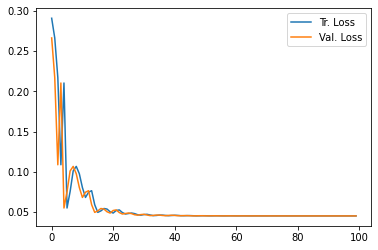

In [37]:
plt.plot(train_loss, label = 'Tr. Loss')
plt.plot(val_loss, label = 'Val. Loss')
plt.legend()

In [38]:
model.eval()  # Asegúrate de que el modelo esté en modo evaluación
y_predicted = []  # Lista para almacenar las predicciones

# Desactivamos el cálculo de gradientes durante la predicción
with torch.no_grad():
    for inputs, _ in train_loader:  # Usamos _ porque no necesitamos las etiquetas en x_testset

        # Hacer predicciones
        outputs = model(inputs)

        # Almacenar las predicciones (por ejemplo, como numpy arrays)
        y_predicted.append(outputs.numpy())  # Si necesitas los resultados como numpy

# Convertir la lista de predicciones en un solo array
y_predicted = np.concatenate(y_predicted, axis=0)

print(y_predicted.shape)  # Esto te dará la forma de las predicciones


(10, 20)


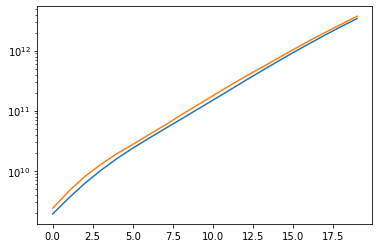

In [39]:
i= 5
plt.plot(10**(y_predicted[i,:] * (max_y - min_y) + min_y))
plt.plot(10**(y_trainset[i,:] * (max_y - min_y) + min_y))
plt.yscale('log')

## Now let's play the real game

Random MSE = 0.12
* 8ch:
    * Seems to converge to MSE = 0.0049 (with dropout but without batch normalization)
    * Seems to converge to MSE = 0.0099 (without dropout but with batch normalization)
    * Seems to converge to MSE = 0.0044 (without dropout nor batch normalization)
    * Seems to converge to MSE = 0.0064 (with dropout and batch normalization)

* 5ch:
    * Seems to converge to MSE =  (with dropout but without batch normalization)
    * Seems to converge to MSE =  (without dropout but with batch normalization)
    * Seems to converge to MSE = 0.0034 (without dropout nor batch normalization)
    * Seems to converge to MSE =  (with dropout and batch normalization)

* 3ch:
    * Seems to converge to MSE =  (with dropout but without batch normalization)
    * Seems to converge to MSE =  (without dropout but with batch normalization)
    * Seems to converge to MSE = 0.0092 (without dropout nor batch normalization)
    * Seems to converge to MSE =  (with dropout and batch normalization)

* SDSS-U:
    * Seems to converge to MSE =  (with dropout but without batch normalization)
    * Seems to converge to MSE =  (without dropout but with batch normalization)
    * Seems to converge to MSE = 0.0148 (without dropout nor batch normalization)
    * Seems to converge to MSE =  (with dropout and batch normalization)

* HI-0:
    * Seems to converge to MSE =  (with dropout but without batch normalization)
    * Seems to converge to MSE =  (without dropout but with batch normalization)
    * Seems to converge to MSE = 0.0089 (without dropout nor batch normalization)
    * Seems to converge to MSE =  (with dropout and batch normalization)

In [395]:
DO = False # If dropout
BN = False # If batch_normalization

class ConvNet(nn.Module):
    def __init__(self, input_shape, intermediate_dim1, intermediate_dim2, intermediate_dim3, intermediate_dim4, output_dim, actFunction):
        super(ConvNet, self).__init__()
        
        # Cálculo de la cantidad de canales de entrada (esto depende de input_shape)
        self.input_channels = input_shape[0]  # Ejemplo: (3, 64, 64), sería 3 canales de entrada
        
        # Definición de las capas de la red
        self.conv1 = nn.Conv2d(self.input_channels, 5, kernel_size=5, stride=1, padding=2)
        if BN: self.bn1 = nn.BatchNorm2d(5)
        self.conv2 = nn.Conv2d(5, 15, kernel_size=5, stride=1, padding=2)
        if BN: self.bn2 = nn.BatchNorm2d(15)
        self.conv3 = nn.Conv2d(15, 30, kernel_size=5, stride=1, padding=2)
        if BN: self.bn3 = nn.BatchNorm2d(30)
        
        # Capa de Flatten
        self.flatten = nn.Flatten()
        
        # Capas completamente conectadas (fully connected)
        self.fc1 = nn.Linear(30 * input_shape[1] // 8 * input_shape[2] // 8, intermediate_dim1)  # Tamaño de salida después de 3 MaxPooling
        if BN: self.bn4 = nn.BatchNorm1d(intermediate_dim1)
        self.fc2 = nn.Linear(intermediate_dim1, intermediate_dim2)
        if BN: self.bn5 = nn.BatchNorm1d(intermediate_dim2)
        self.fc3 = nn.Linear(intermediate_dim2, intermediate_dim3)
        if BN: self.bn6 = nn.BatchNorm1d(intermediate_dim3)
        self.fc4 = nn.Linear(intermediate_dim3, intermediate_dim4)
        self.fc5 = nn.Linear(intermediate_dim4, output_dim)
        
        # Función de activación
        self.actFunction = actFunction

        # Dropout
        if DO: self.dropout_conv = nn.Dropout2d(p=0.2)  # Dropout para capas convolucionales
        if DO: self.dropout_fc = nn.Dropout(p=0.2)  # Dropout para capas completamente conectadas

    def forward(self, x):
        # Primera capa convolucional
        x = self.conv1(x)
        if BN: x = self.bn1(x)
        x = self.actFunction(x)
        if DO: x = self.dropout_conv(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)
        
        # Segunda capa convolucional
        x = self.conv2(x)
        if BN: x = self.bn2(x) 
        x = self.actFunction(x)
        if DO: x = self.dropout_conv(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)
        
        # Tercera capa convolucional
        x = self.conv3(x)
        if BN: x = self.bn3(x) 
        x = self.actFunction(x)
        if DO: x = self.dropout_conv(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)
        
        # Aplanamiento
        x = self.flatten(x)
        
        # Capas completamente conectadas
        x = self.fc1(x)
        if BN: x = self.bn4(x)
        x = self.actFunction(x)
        if DO: x = self.dropout_fc(x)
        
        x = self.fc2(x)
        if BN: x = self.bn5(x)
        x = self.actFunction(x)
        if DO: x = self.dropout_fc(x)
        
        x = self.fc3(x)
        if BN: x = self.bn6(x)
        x = self.actFunction(x)
        if DO: x = self.dropout_fc(x)
        
        x = self.fc4(x)  # Capa final antes de la salida (sin activación, o con 'linear' como en el código original)
        x = self.fc5(x)  # Capa de salida
        
        return x
    

actFunction = torch.relu  # Función de activación ReLU

In [396]:
# Crear los DataLoaders para entrenamiento y validación
train_dataset = CustomDataset(x_trainset, y_trainset)
val_dataset   = CustomDataset(x_valset, y_valset)
test_dataset  = CustomDataset(x_testset, y_testset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [398]:
name = '8ch'

In [ ]:
num_epochs = 100
patience = 10  # Número de épocas a esperar antes de detener el entrenamiento si no hay mejora

niter = 10

train_loss_list = []
val_loss_list = []
for j in range(2,niter):
    random_indices = np.random.choice(np.arange(train_size), replace = True, size = train_size)
    
    train_dataset = CustomDataset(x_trainset[random_indices], y_trainset[random_indices])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Crear el modelo
    model = ConvNet(input_shape, intermediate_dim1, intermediate_dim2, intermediate_dim3, intermediate_dim4, output_dim, actFunction)

    criterion = nn.MSELoss()  # Para un problema de regresión o imagen de salida continua
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Mostrar la estructura del modelo
    #print(model)

    best_val_loss = float('inf')  # Inicializar con un valor muy alto
    epochs_without_improvement = 0  # Contador para el early stopping

    # Ruta donde se guardará el mejor modelo
    best_model_path = '../data/models/best_model_' + name + '_' + str(j) + '.pth'

    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()  # Configura el modelo en modo entrenamiento
        running_train_loss = 0.0
        for inputs, true_vals in train_loader:
            # Zero gradientes
            optimizer.zero_grad()

            # Paso hacia adelante
            outputs = model(inputs)

            # Calcular la pérdida
            loss = criterion(outputs, true_vals)

            # Paso hacia atrás (backpropagation)
            loss.backward()

            # Actualizar los pesos
            optimizer.step()

            # Sumar la pérdida del lote
            running_train_loss += loss.item()

        # Promedio de la pérdida de entrenamiento
        avg_train_loss = running_train_loss / len(train_loader)
        train_loss.append(avg_train_loss)

        # Validación
        model.eval()  # Configura el modelo en modo evaluación
        running_val_loss = 0.0
        with torch.no_grad():  # No calculamos gradientes en validación
            for inputs, true_vals in val_loader:

                # Paso hacia adelante (sin gradientes)
                outputs = model(inputs)

                # Calcular la pérdida
                loss = criterion(outputs, true_vals)
                # Sumar la pérdida de validación
                running_val_loss += loss.item()

        # Promedio de la pérdida de validación
        avg_val_loss = running_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            print(f'Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...')
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0  # Reiniciar el contador
            # Guardar el mejor modelo
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_without_improvement += 1
            print(f'Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}')

        # Detener el entrenamiento si no hay mejora en `patience` épocas
        if epochs_without_improvement >= patience:
            print(f'Early stopping after {patience} epochs without improvement.')
            break
        # Imprimir estadísticas de la época
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}")

    val_loss_list.append(val_loss)
    train_loss_list.append(train_loss)
    plt.plot(train_loss, label = 'Tr. Loss')
    plt.plot(val_loss, label = 'Val. Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('../graphs/Loss_' + name + '_' + str(j) + '.pdf')
    plt.clf()

Validation loss improved from inf to 0.0198. Saving model...
Epoch [1/100], Train Loss: 0.0270, Validation Loss: 0.0198
Validation loss improved from 0.0198 to 0.0176. Saving model...
Epoch [2/100], Train Loss: 0.0197, Validation Loss: 0.0176
Validation loss improved from 0.0176 to 0.0132. Saving model...
Epoch [3/100], Train Loss: 0.0165, Validation Loss: 0.0132
Validation loss improved from 0.0132 to 0.0085. Saving model...
Epoch [4/100], Train Loss: 0.0118, Validation Loss: 0.0085
Validation loss improved from 0.0085 to 0.0067. Saving model...
Epoch [5/100], Train Loss: 0.0085, Validation Loss: 0.0067
Validation loss did not improve. Patience: 1/10
Epoch [6/100], Train Loss: 0.0071, Validation Loss: 0.0070
Validation loss did not improve. Patience: 2/10
Epoch [7/100], Train Loss: 0.0071, Validation Loss: 0.0068
Validation loss did not improve. Patience: 3/10
Epoch [8/100], Train Loss: 0.0080, Validation Loss: 0.0070
Validation loss improved from 0.0067 to 0.0063. Saving model...
Epo

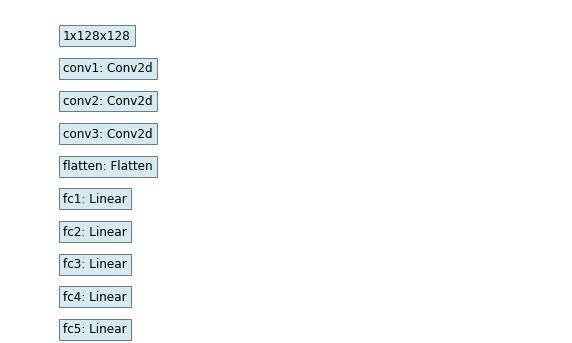

In [364]:
layers = []
for lname, layer in model.named_children():
    layers.append(f"{lname}: {layer.__class__.__name__}")
    

plt.figure(figsize=(10, 6))
plt.text(0.1, 0.9, f'{nch}x{npix}x{npix}', fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.5))

for i in range(len(layers)):
    layer = layers[i]
    plt.text(0.1, 0.9 - (i+1) * 0.1, layer, fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.5))

plt.axis('off')
#plt.title('CNN Architecture', fontsize=16)
plt.savefig('../graphs/Architecture_' + name + '.pdf')

In [312]:
!ls -latr ../data/models/

total 132596
drwxrwxr-x 4 martinrios martinrios     4096 mar 10 11:42 ..
-rw-rw-r-- 1 martinrios martinrios 16992406 mar 13 14:28 best_model_8ch_BN+DO.pth
-rw-rw-r-- 1 martinrios martinrios 16963822 mar 13 14:52 best_model_8ch_DO.pth
-rw-rw-r-- 1 martinrios martinrios 16992128 mar 13 15:02 best_model_8ch_BN.pth
-rw-rw-r-- 1 martinrios martinrios 16962162 mar 13 15:12 best_model_5ch.pth
-rw-rw-r-- 1 martinrios martinrios 16961138 mar 13 15:23 best_model_3ch.pth
-rw-rw-r-- 1 martinrios martinrios 16960238 mar 13 15:31 best_model_SDSS-U.pth
drwxrwxr-x 2 martinrios martinrios     4096 mar 13 15:44 .
-rw-rw-r-- 1 martinrios martinrios 16960114 mar 13 15:45 best_model_HI0.pth
-rw-rw-r-- 1 martinrios martinrios 16963634 mar 14 11:25 best_model_8ch.pth


In [365]:
best_model_path = '../data/models/best_model_' + name + '.pth'

In [366]:
model.load_state_dict(torch.load(best_model_path, weights_only=True))
model.eval() 

ConvNet(
  (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 15, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(15, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=7680, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=20, bias=True)
)

In [367]:
model.eval()  # Asegúrate de que el modelo esté en modo evaluación
y_predicted = []  # Lista para almacenar las predicciones

# Desactivamos el cálculo de gradientes durante la predicción
with torch.no_grad():
    test_loss = 0
    for inputs, true_vals in test_loader:  # Usamos _ porque no necesitamos las etiquetas en x_testset

        # Hacer predicciones
        outputs = model(inputs)

        # Almacenar las predicciones (por ejemplo, como numpy arrays)
        y_predicted.append(outputs.numpy())  # Si necesitas los resultados como numpy
        test_loss += criterion(outputs, true_vals)

test_loss = test_loss / len(test_loader)
print(f'Test Loss = {test_loss}')  # Esto te dará la forma de las predicciones
     
# Convertir la lista de predicciones en un solo array
y_predicted = np.concatenate(y_predicted, axis=0)

print(y_predicted.shape)  # Esto te dará la forma de las predicciones

M_pred = 10**(y_predicted * (max_y - min_y) + min_y)
M_real = 10**(y_testset * (max_y - min_y) + min_y)

mass_quantiles = np.percentile((M_pred / M_real), [25, 50, 75], axis=0)

Test Loss = 0.014828545972704887
(298, 20)


In [368]:
y_predicted_from_stellar = np.zeros((test_size, 20))
y_predicted_from_stellar_std = np.zeros((test_size, 20))
for i in range(test_size):
    dm_aux, dm_std = dm_from_stellar(labels[test_ind[i],1,:],num_smass_bins = 10)
    y_predicted_from_stellar[i,:] = dm_aux
    y_predicted_from_stellar_std[i,:] = dm_std

In [369]:
y_predicted_random = np.random.uniform(0,1, size=(298,20))
M_pred_random = 10**(y_predicted_random * (max_y - min_y) + min_y)

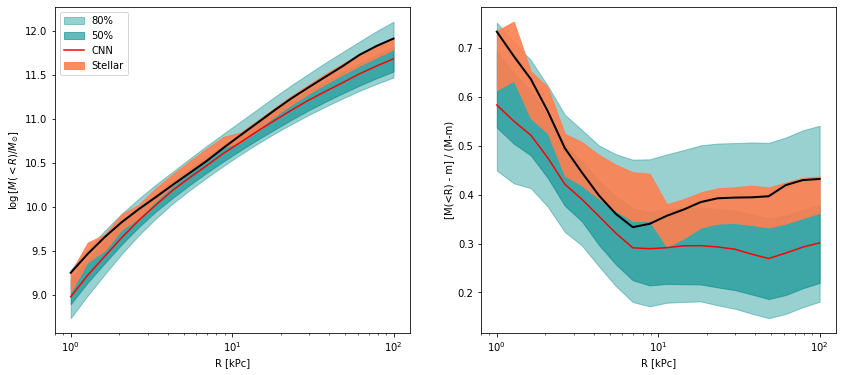

In [370]:
i = np.random.randint(len(y_predicted))

fig,ax = plt.subplots(1,2, sharex = True, figsize = (14,6))

#ax[0].fill_between(R_bins, max_y, min_y, color = 'darkcyan', alpha = 0.2)
ax[0].fill_between(R_bins, (dm_quantiles[0,:]), (dm_quantiles[3,:]), color = 'darkcyan', alpha = 0.4, label = '80%' )
ax[0].fill_between(R_bins, (dm_quantiles[1,:]), (dm_quantiles[2,:]), color = 'darkcyan', alpha = 0.6, label = '50%' )
#ax[0].fill_between(R_bins, 10**(dm_prior_profile + dm_prior_profile_std), 10**(dm_prior_profile - dm_prior_profile_std), color = 'darkcyan', alpha = 0.2)

ax[0].plot(R_bins, (np.log10(M_pred[i,:])), c = 'red', label = 'CNN')

#ax[0].plot(R_bins, 10**y_predicted_from_stellar[i,:], color = 'coral')
ax[0].fill_between(R_bins, ((y_predicted_from_stellar[i,:] + y_predicted_from_stellar_std[i,:])), 
                 ((y_predicted_from_stellar[i,:] - y_predicted_from_stellar_std[i,:])), color = 'coral', alpha = 0.9, label = 'Stellar')

ax[0].plot(R_bins, (np.log10(M_real[i,:])), c = 'black', lw =2)
ax[0].legend()
ax[0].set_xlabel('R [kPc]')
ax[0].set_ylabel('$\log{[M(<R) / M_{\odot}]}$')


#ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('R [kPc]')
ax[1].set_ylabel('[M(<R) - m] / (M-m)')

#ax[1].fill_between(R_bins, max_y, min_y, color = 'darkcyan', alpha = 0.2)
ax[1].fill_between(R_bins, (dm_quantiles[0,:] - min_y) / (max_y - min_y), (dm_quantiles[3,:] - min_y) / (max_y - min_y), color = 'darkcyan', alpha = 0.4, label = '80%' )
ax[1].fill_between(R_bins, (dm_quantiles[1,:] - min_y) / (max_y - min_y), (dm_quantiles[2,:] - min_y) / (max_y - min_y), color = 'darkcyan', alpha = 0.6, label = '50%' )
#ax[1].fill_between(R_bins, 10**(dm_prior_profile + dm_prior_profile_std), 10**(dm_prior_profile - dm_prior_profile_std), color = 'darkcyan', alpha = 0.2)

ax[1].plot(R_bins, (np.log10(M_pred[i,:]) - min_y) / (max_y - min_y), c = 'red', label = 'CNN')

#ax[1].plot(R_bins, 10**y_predicted_from_stellar[i,:], color = 'coral')
ax[1].fill_between(R_bins, ((y_predicted_from_stellar[i,:] + y_predicted_from_stellar_std[i,:]) - min_y) / (max_y - min_y), 
                 ((y_predicted_from_stellar[i,:] - y_predicted_from_stellar_std[i,:]) - min_y) / (max_y - min_y), color = 'coral', alpha = 0.9, label = 'Stellar')

ax[1].plot(R_bins, (np.log10(M_real[i,:]) - min_y) / (max_y - min_y), c = 'black', lw =2)

#ax[1].yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('R [kPc]')
ax[1].set_ylabel('[M(<R) - m] / (M-m)')

plt.savefig('../graphs/DMfromStellar_' + str(properties[test_ind[i],0]) + '_' + name + '.pdf')

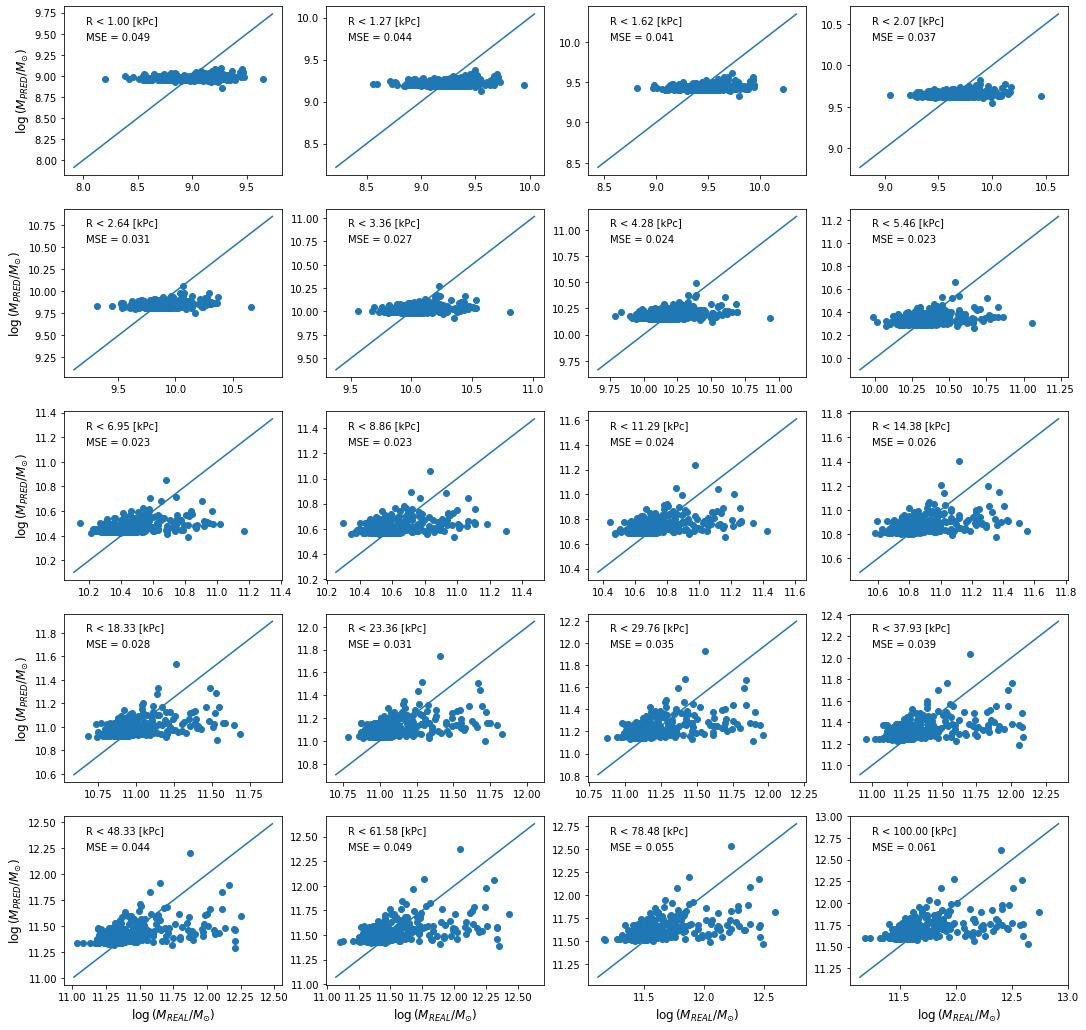

In [371]:
fig, ax = plt.subplots(5,4, figsize = (18,18))

for i in range(5):
    for j in range(4):

        ax[i,j].scatter(np.log10(M_real[:,i*4+j]), np.log10(M_pred[:,i*4+j]))
        ax[i,j].plot([min_y[i*4+j], max_y[i*4+j]], [min_y[i*4+j], max_y[i*4+j]])
        
        if i == 4: ax[i,j].set_xlabel('$\log{(M_{REAL} / M_{\odot})}$', fontsize = 12)
        if j == 0: ax[i,j].set_ylabel('$\log{(M_{PRED} / M_{\odot})}$', fontsize = 12)
        
        ax[i,j].text(0.1,0.8,'MSE = {:.3f}'.format(mean_squared_error(np.log10(M_real[:,i*4+j]), np.log10(M_pred[:,i*4+j]))), transform = ax[i,j].transAxes)
        ax[i,j].text(0.1,0.9,'R < {:.2f} [kPc]'.format(R_bins[i*4+j]), transform = ax[i,j].transAxes)
        
plt.savefig('../graphs/RealVSPred_' + name + '.pdf')

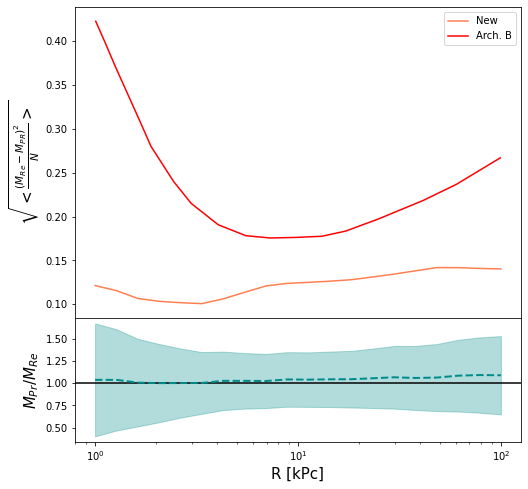

In [372]:
fig,ax = plt.subplots(2,1, figsize = (8,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)

mse = np.sqrt(mean_squared_error(y_testset, y_predicted, multioutput = 'raw_values')) # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
std = np.sqrt(np.std((y_testset - y_predicted)**2, axis = 0))
mse_random = np.sqrt(mean_squared_error(y_testset, y_predicted_random, multioutput = 'raw_values')) # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
std_random = np.sqrt(np.std((y_testset - y_predicted_random)**2, axis = 0))
mse_prior = np.abs(max_y - min_y)

#for i in range(test_size):
#    ax[0].plot(R_bins, np.abs(y_testset[i,:] - y_predicted[i,:]), alpha = 0.2, c = 'black')

ax[0].plot(R_bins, mse, color = 'coral', label = 'New')
#ax[0].plot(R_bins, mse_random, color = 'coral', label = 'Random')
#ax[0].fill_between(R_bins, mse + std, mse - std, color = 'red', alpha = 0.3)

#ax[0].plot(R_bins, mse_prior, color = 'red')
ax[0].plot(arqB_8ch[:,0], arqB_8ch[:,1], color = 'red', label = 'Arch. B')

ax[0].set_ylabel('$\sqrt{ <\\frac{(M_{Re} - M_{PR})^2}{N}> }$', fontsize = 15)
#ax[0].set_xlabel('R [kPc]')
ax[0].set_xscale('log')
ax[0].legend()

mean_mass_ratio = np.mean(M_pred / M_real, axis = 0)
std_mass_ratio = np.std(M_pred / M_real, axis = 0)
mean_mass_ratio_random = np.mean(M_pred_random / M_real, axis = 0)
std_mass_ratio_random = np.std(M_pred_random / M_real, axis = 0)

#for i in range(test_size):
    #ax[1].plot(R_bins, M_pred[i,:] / M_real[i,:], color = 'black', alpha = 0.05)
ax[1].axhline(y = 1, color = 'black')
ax[1].plot(R_bins, mean_mass_ratio, color = 'darkcyan', lw = 2, ls = '--')
ax[1].fill_between(R_bins, mean_mass_ratio + std_mass_ratio, mean_mass_ratio - std_mass_ratio, color = 'darkcyan', alpha = 0.3)

#ax[1].fill_between(R_bins, mean_mass_ratio_random + std_mass_ratio_random, mean_mass_ratio_random - std_mass_ratio_random, color = 'red', alpha = 0.3)

#ax[1].plot(R_bins, mass_quantiles[2,:], color = 'black', lw = 2, ls = '--')

ax[1].set_xlabel('R [kPc]', fontsize = 15)
ax[1].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 15)
plt.savefig('../graphs/MSE_' + name + '.pdf')

In [373]:
quantiles = np.percentile((y_testset - y_predicted)**2, [25, 50, 75], axis=0)

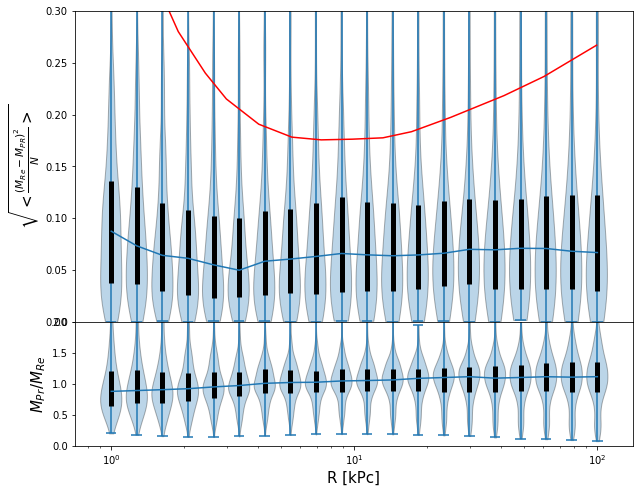

In [374]:
fig,ax = plt.subplots(2,1, figsize = (10,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)

parts = ax[0].violinplot(np.sqrt((y_testset - y_predicted)**2), positions=R_bins, widths=R_bins*0.2)
for pc in parts['bodies']:  
    pc.set_facecolor('#1f77b4')  # Color azul  
    pc.set_edgecolor('black')
    pc.set_alpha(0.3) 
    
ax[0].plot(R_bins, np.sqrt(quantiles[1,:]), color = '#1f77b4' , zorder=4)
ax[0].vlines(R_bins, np.sqrt(quantiles[0,:]), np.sqrt(quantiles[2,:]), color='k', linestyle='-', lw=5)
#ax[0].plot(R_bins, np.sqrt(quantiles[0,:]), color = '#1f77b4' , zorder=4)
#ax[0].plot(R_bins, np.sqrt(quantiles[2,:]), color = '#1f77b4' , zorder=4)
ax[0].set_xscale('log')
#ax[0].plot(R_bins, mse/mse_prior, color = 'red')
#ax[0].plot(R_bins, mse_prior, color = 'green')
#ax[0].fill_between(R_bins, mse + std, mse - std, color = 'red', alpha = 0.3)
ax[0].set_ylim(0,0.3)
ax[0].plot(arqB_8ch[:,0], arqB_8ch[:,1], color = 'red')
ax[0].set_ylabel('$\sqrt{ <\\frac{(M_{Re} - M_{PR})^2}{N}> }$', fontsize = 15)

parts1 = ax[1].violinplot((M_pred / M_real), positions=R_bins, widths=R_bins*0.2)
for pc in parts1['bodies']:  
    pc.set_facecolor('#1f77b4')  # Color azul  
    pc.set_edgecolor('black')
    pc.set_alpha(0.3) 
    
ax[1].plot(R_bins, mass_quantiles[1,:], color = '#1f77b4' , zorder=4)
ax[1].vlines(R_bins, mass_quantiles[0,:], mass_quantiles[2,:], color='k', linestyle='-', lw=5)
ax[1].set_ylim(0,2)
ax[1].set_xlabel('R [kPc]', fontsize = 15)
ax[1].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 15)

plt.savefig('../graphs/MSE_v2_' + name + '.pdf')

### Saliency maps 

In [84]:
!ls -latr ../data/models/

total 49740
drwxrwxr-x 4 martinrios martinrios     4096 mar 10 11:42 ..
-rw-rw-r-- 1 martinrios martinrios 16963634 mar 13 14:09 best_model_8ch.pth
drwxrwxr-x 2 martinrios martinrios     4096 mar 13 14:26 .
-rw-rw-r-- 1 martinrios martinrios 16992406 mar 13 14:28 best_model_8ch_BN+DO.pth
-rw-rw-r-- 1 martinrios martinrios 16963822 mar 13 14:52 best_model_8ch_DO.pth


In [375]:
model.eval()
images, _ = next(iter(test_loader))

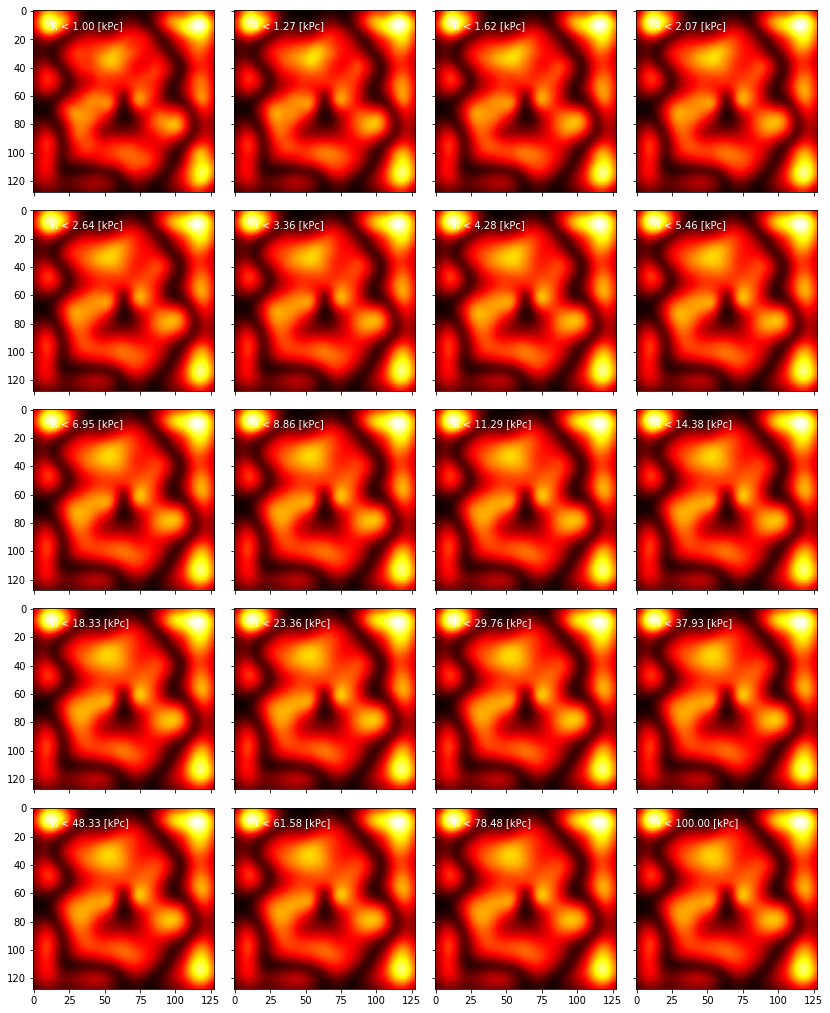

In [379]:
nimg = 1
ch = 0
image = images[nimg].unsqueeze(0)

fig, ax = plt.subplots(5,4, figsize = (18,18), sharex = True, sharey = True)
plt.subplots_adjust(wspace=-0.5, hspace=0.1)

for i in range(5):
    for j in range(4):
        
        saliency_map = estimate_saliency_map(model, image, radial_bin = i*4+j, noise_levels = np.array([1e-3]).reshape(1,1,1,1),
                                 num_perturbations = 20)
        
        norm_saliency_map = (saliency_map[:,:] - saliency_map[:,:].min()) / (saliency_map[:,:].max() - saliency_map[:,:].min())

        smoothed_saliency_map = gaussian_filter(norm_saliency_map, sigma=3)  # Adjust sigma for desired smoothing

        ax1 = ax[i,j].imshow(smoothed_saliency_map, cmap='hot')
        
        #ax[i,j].text(0.1,0.8,'MSE = {:.3f}'.format(mean_squared_error(np.log10(M_real[:,i*4+j]), np.log10(M_pred[:,i*4+j]))), transform = ax[i,j].transAxes)
        ax[i,j].text(0.1,0.9,'R < {:.2f} [kPc]'.format(R_bins[i*4+j]), transform = ax[i,j].transAxes, color = 'white')
        ax[i,j].set_xlabel('')
        ax[i,j].set_ylabel('')

plt.savefig('../graphs/SaliencyMaps_' + str(properties[test_ind[nimg],0]) + '_ch_' + str(ch) + '_' + name + '.pdf')

### Grad-CAM

In [324]:

from torch.autograd import Function

In [325]:
# Hook to get the feature maps and gradients from the last convolutional layer
class FeatureExtractor:
    def __init__(self, model):
        self.model = model
        self.feature_maps = None
        self.gradients = None

    def save_features(self, module, input, output):
        # Save the feature maps
        self.feature_maps = output

    def save_grads(self, module, input, output):
        # Save the gradients
        self.gradients = output

    def register_hooks(self):
        # Register hooks on the last convolutional layer
        for name, module in self.model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                module.register_forward_hook(self.save_features)
                module.register_backward_hook(self.save_grads)

    def clear_hooks(self):
        self.feature_maps = None
        self.gradients = None

# Grad-CAM computation
def grad_cam(model, image, target_index=None):
    model.eval()

    # Feature extractor for the last convolutional layer
    extractor = FeatureExtractor(model)
    extractor.register_hooks()

    # Forward pass
    output = model(image)
    
    # Choose which output to backpropagate with if it's a regression task
    if target_index is None:
        target_index = 0  # You can choose any of the 20 outputs here

    # Backward pass for the selected target output
    model.zero_grad()
    output[0, target_index].backward(retain_graph=True)

    # Get the gradients and feature maps
    gradients = extractor.gradients
    feature_maps = extractor.feature_maps

    # Pool the gradients across all the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3], keepdim=True)

    # Weight the feature maps by the pooled gradients
    for i in range(feature_maps.shape[1]):
        feature_maps[:, i, :, :] *= pooled_gradients[:, i, :, :]

    # Create the Grad-CAM heatmap by summing the weighted feature maps
    grad_cam_map = torch.sum(feature_maps, dim=1).squeeze()

    # Apply ReLU to the heatmap
    grad_cam_map = torch.relu(grad_cam_map)

    # Normalize the heatmap
    grad_cam_map = grad_cam_map.detach().cpu().numpy()
    grad_cam_map = (grad_cam_map - np.min(grad_cam_map)) / (np.max(grad_cam_map) - np.min(grad_cam_map))

    return grad_cam_map

# Plot the Grad-CAM heatmap
def plot_grad_cam(image, grad_cam_map):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Convert the image back to numpy for visualization
    original_image = image[0].permute(1, 2, 0).cpu().numpy()
    original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())  # Normalize

    ax[0].imshow(original_image)
    ax[0].axis('off')
    ax[0].set_title("Original Image")

    ax[1].imshow(grad_cam_map, cmap='jet')
    ax[1].axis('off')
    ax[1].set_title("Grad-CAM Heatmap")

    plt.show()

In [327]:
image.shape

torch.Size([1, 8, 128, 128])

In [333]:
model.eval()

# Feature extractor for the last convolutional layer
extractor = FeatureExtractor(model)
extractor.register_hooks()

# Forward pass
output = model(image)

target_index = 0  # You can choose any of the 20 outputs here

# Backward pass for the selected target output
model.zero_grad()
output[0, target_index].backward(retain_graph=True)

# Get the gradients and feature maps
gradients = extractor.gradients
feature_maps = extractor.feature_maps


In [352]:
feature_maps.shape

torch.Size([1, 30, 32, 32])

In [350]:

# Pool the gradients across all the channels
pooled_gradients = torch.mean(gradients[0], dim=(0,1),keepdim = True)

In [351]:
pooled_gradients.shape

torch.Size([1, 1, 128, 128])

In [326]:
# Test the Grad-CAM on a specific image
for images, targets in test_loader:
    image = images[0].unsqueeze(0)  # Select the first image and add batch dimension
    grad_cam_map = grad_cam(model, image, target_index=0)  # Compute Grad-CAM for the first output
    plot_grad_cam(image, grad_cam_map)
    break  # Only process the first image

/home/martinrios/.virtualenvs/ml4dm/lib/python3.8/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


TypeError: mean() received an invalid combination of arguments - got (tuple, keepdim=bool, dim=list), but expected one of:
 * (Tensor input, *, torch.dtype dtype = None)
      didn't match because some of the keywords were incorrect: keepdim, dim
 * (Tensor input, tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None, Tensor out = None)
 * (Tensor input, tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None, Tensor out = None)


# Deprecated

In [ ]:
#model.load_state_dict(torch.load('../data/models/best_model_8ch.pth', weights_only=True))
#noise_levels = np.array([1e-1,1e-1,1e-1,1e-1,1e-1,1e-1,1e-1,1e-1]).reshape(1,8,1,1)

# Ensure the model is in evaluation mode
model.eval()

# Get one batch of test images
#%for images, labels in test_loader:
images, _ = next(iter(test_loader))
nimg = 20
nbin = 1
image = images[nimg].unsqueeze(0)

noise_levels = np.array([1e-3,1e-3,1e-3,1e-3,1e-3]).reshape(1,nch,1,1)
#%noise_levels = np.array([1e-3,1e-3,1e-3,1e-3,1e-3,1e-2,1e-5,1e-7]).reshape(1,8,1,1)
#%noise_levels = 2.5*np.median(image.detach().numpy(), axis = (0,2,3)).reshape(1,8,1,1)
# Use only the first image from the batch
image.requires_grad = True  # Enable gradient computation


# Initialize an empty tensor to accumulate gradients
accumulated_saliency = torch.zeros_like(image)

# Number of forward passes for averaging
num_perturbations = 200  # Adjust the number of perturbations as needed

#%for _ in range(num_perturbations):
    # Forward pass
#%    output = model(image)  # Output shape: (1, 20)

#%    model.zero_grad()  # Zero gradients before each backward pass

    # Compute gradients for the i-th output (explicitly providing gradient tensor)
#%    output[0, nbin].backward(retain_graph=True)

    # Accumulate gradients
#%    accumulated_saliency += image.grad
num_perturbations = 20
for _ in range(num_perturbations):
    # Add Gaussian noise to the image
    noisy_image = image + torch.Tensor(noise_levels) * torch.randn_like(image)

    # Forward pass
    output = model(noisy_image)

    # Zero out any previous gradients
    model.zero_grad()

    # Compute the gradient of the output with respect to the target index
    output[0, nbin].backward(retain_graph=True)

    # Accumulate the gradients
    accumulated_saliency += image.grad

# Average the accumulated saliency maps
accumulated_saliency /= num_perturbations

# Get the final saliency map (absolute value of gradients)
saliency_map = accumulated_saliency.abs().squeeze().detach().cpu().numpy()
    

In [120]:
# build model
model = Sequential()

model.add(Conv2D(filters = 5, kernel_size = (5,5), strides = 1 , padding = 'same', input_shape = input_shape))
#model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 15, kernel_size = (5,5), strides = 1 , padding = 'same'))
#model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 30, kernel_size = (5,5), strides = 1 , padding = 'same'))
#model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Dropout(0.2)) 
model.add(Flatten())

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim1, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim2, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim3, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim4, activation = 'linear'))

model.add(Dense(output_dim, name = 'output'))

model.summary()

# instantiate model
optimizer = optimizers.Adam(learning_rate = 1e-5, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model.compile(optimizer = optimizer, loss = 'mse', metrics=['mae','mse'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 128, 5)       1005      
                                                                 
 batch_normalization_7 (Bat  (None, 128, 128, 5)       20        
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 128, 128, 5)       0         
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 64, 64, 5)         0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 15)        1890      
                                                                 
 batch_normalization_8 (Bat  (None, 64, 64, 15)       

In [103]:
batch_size = 32
epochs     = 250
history = model.fit(x_trainset[:batch_size], y_trainset[:batch_size],
                   epochs = epochs,
                   validation_data = (x_trainset[:batch_size], y_trainset[:batch_size]))

Epoch 1/250
1/1 [==============================] - 1s 1s/step - loss: 0.3322 - mae: 0.5282 - mse: 0.3322 - val_loss: 0.3210 - val_mae: 0.5184 - val_mse: 0.3210
Epoch 2/250
1/1 [==============================] - 0s 265ms/step - loss: 0.3210 - mae: 0.5184 - mse: 0.3210 - val_loss: 0.3104 - val_mae: 0.5089 - val_mse: 0.3104
Epoch 3/250
1/1 [==============================] - 0s 275ms/step - loss: 0.3104 - mae: 0.5089 - mse: 0.3104 - val_loss: 0.3009 - val_mae: 0.5002 - val_mse: 0.3009
Epoch 4/250
1/1 [==============================] - 0s 345ms/step - loss: 0.3009 - mae: 0.5002 - mse: 0.3009 - val_loss: 0.2919 - val_mae: 0.4918 - val_mse: 0.2919
Epoch 5/250
1/1 [==============================] - 0s 314ms/step - loss: 0.2919 - mae: 0.4918 - mse: 0.2919 - val_loss: 0.2837 - val_mae: 0.4839 - val_mse: 0.2837
Epoch 6/250
1/1 [==============================] - 0s 291ms/step - loss: 0.2837 - mae: 0.4839 - mse: 0.2837 - val_loss: 0.2761 - val_mae: 0.4765 - val_mse: 0.2761
Epoch 7/250
1/1 [========

In [ ]:
y_predicted = model.predict(x_testset) * (max_y - min_y) + min_y

In [ ]:
from pts.visual.rgbimage import RGBImage
import astropy.units as u

img_array = x_testset[nimg,ch,:,:] * (max_x - min_x) + min_x
img_array = np.stack((img_array, img_array, img_array), axis=-1) * u.Unit('MJy/sr')
image = RGBImage(img_array.value)
fmin = 1e-5 * u.MJy/u.sr
fmax = 1e3 * u.MJy/u.sr
image.setRange(fmin.value, fmax.value)
image.applyLog()     # Aplicar transformación logarítmica
image.applyCurve()   # Aplicar curva de color
image.plot()